In [178]:
import os
import cv2
import glob
import pickle
import numpy as np
import pylab as plt
import full_pipeline as fp
from IPython.display import Image

# This is deprecated: import Ipython.html.widgets instead:
import ipywidgets

%matplotlib inline

In [179]:
path2calib_im = "./camera_cal/"
path2test_im = "./test_images/"
pattern = "*.jpg"

In [180]:
camera_calibration = pickle.load(open(path2calib_im + "calibration_data.pkl", "rb" ))
perspective_matrix = pickle.load(open("./perspective_mat.pkl", "rb"))
M = perspective_matrix['M']
inv_M = perspective_matrix['inv_M']

test_images = glob.glob(path2test_im + pattern)

laboratory_rat_yellow = cv2.imread(test_images[1])
laboratory_rat_yellow = laboratory_rat_yellow[...,::-1]

laboratory_rat_white = cv2.imread(test_images[7])
laboratory_rat_white = laboratory_rat_white[...,[2, 1, 0]]

Following the pipeline defined in Pipline_part1.ipynb (copied here)

```python
# Let's define a function that carry on with all the steps

def pipeline(image, camera_calibration, perspective_matrix):
    
    # Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    # Already done in Camera calibration.ipynb
    
    # Apply a distortion correction to raw images.
    undistorted = undistort(image, camera_calibration)
    
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    thresholded = threshold(undistorted)
    
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    birds_eye = perspective(thresholded, perspective_matrix)
    
    # Detect lane pixels and fit to find the lane boundary.
    detected_lanes, polynomials = detect_lanes(birds_eye)
    
    # Determine the curvature of the lane and vehicle position with respect to center.
    curvature = get_curvature(detected_lanes, polynomials)
    
    # Warp the detected lane boundaries back onto the original image.
    image_lanes = get_original_with_lanes()
    
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    final_image = visualization(image_lanes, curvature, vehicle_position)
    
    # TODO: where to get vehicle_position?
    
    return final_image
```

The first 4 points are done, now we need to continue with detect_lanes function

## Detect lane pixels and fit to find the lane boundary.

In [181]:
undistorted = fp.undistort(laboratory_rat_yellow, camera_calibration)
thresholded, _, _ = fp.threshold(undistorted)
birds_eye_yellow = fp.perspective(thresholded, M)

undistorted = fp.undistort(laboratory_rat_white, camera_calibration)
thresholded, _, _ = fp.threshold(undistorted)
birds_eye_white = fp.perspective(thresholded, M)

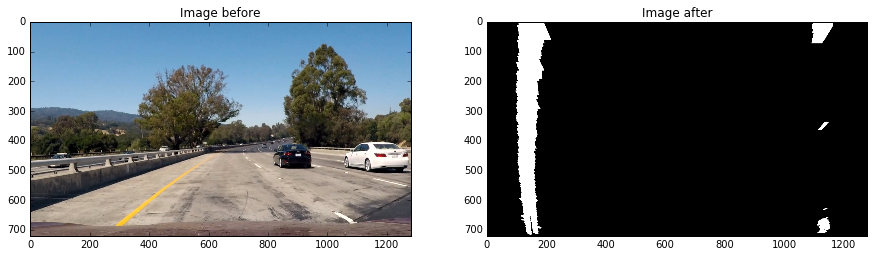

In [6]:
fp.visualize_before_after(laboratory_rat_yellow, birds_eye_yellow, cmap='gray')

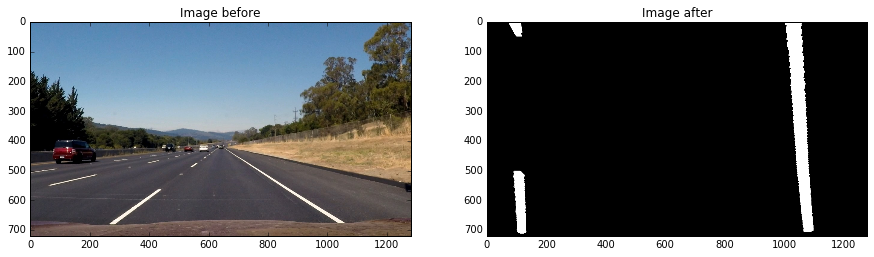

In [7]:
fp.visualize_before_after(laboratory_rat_white, birds_eye_white, cmap='gray')

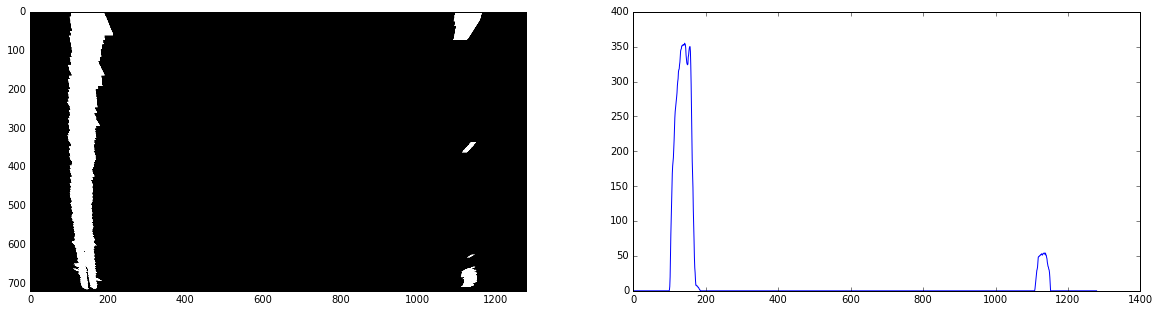

In [27]:
histogram = np.sum(birds_eye_yellow[int(birds_eye_yellow.shape[0]/2):,:], axis=0)

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
_ = plt.imshow(birds_eye_yellow, cmap='gray')
plt.subplot(1,2,2)
_ = plt.plot(histogram)

In [277]:
def detect_lanes(image, base=None):
    
    if base:
        leftx_base = base[0]
        rightx_base = base[1]
        
    else:     
        # Let's find a starting point
        histogram = np.sum(image[int(image.shape[0]/2):,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    l_windows = list()
    r_windows = list()

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Store this window for visualization purposes
        l_windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
        r_windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) \
                          & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) \
                           & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    windows = [l_windows, r_windows]
    pixels = [left_lane_inds, right_lane_inds]
    poly = [left_fit, right_fit]
    
    return windows, pixels, poly

In [278]:
def visualize_detected_lines(image, windows, pixels, poly):
    
    l_windows = windows[0]
    r_windows = windows[1]
    
    left_lane_inds = pixels[0]
    right_lane_inds = pixels[1]
    
    left_fit = poly[0]
    right_fit = poly[1]
    
    red = [255, 0, 0]
    blue = [0, 0, 255]
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    
    # Draw windows
    for l_window, r_window in zip(l_windows, r_windows):
        cv2.rectangle(out_img,l_window[0], l_window[1],(0,255,0), 2) 
        cv2.rectangle(out_img,r_window[0], r_window[1],(0,255,0), 2) 
    
    # Draw in-windows pixels' lanes
    nonzero = image.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = blue
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = red
    
    """
    for l_window, r_window in zip(l_windows, r_windows):
        out_image[l_window][ out_image[l_window] == 0] = blue
        out_image[r_window][ out_image[r_window] == 0] = red
    """
    
    # Dray fitted curves
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    plt.figure(figsize=(10, 8))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow', linewidth=6)
    plt.plot(right_fitx, ploty, color='yellow', linewidth=6)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [279]:
windows, pixels, poly = detect_lanes(birds_eye_yellow)

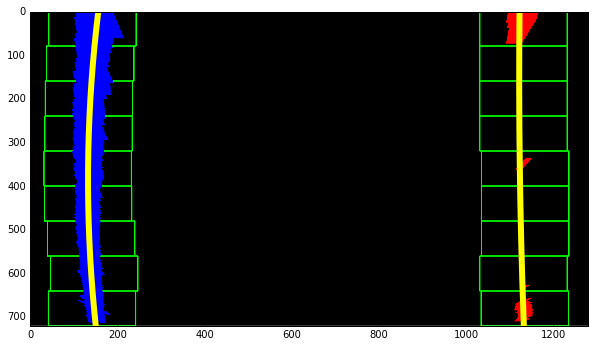

In [280]:
visualize_detected_lines(birds_eye_yellow, windows, pixels, poly)

## Determine the curvature of the lane and vehicle position with respect to center.

In [281]:
def get_curvature(image, poly):
    
    left_fit = poly[0]
    right_fit = poly[1]
    
    y_eval = image.shape[0]
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.abs(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.abs(2*right_fit[0])
    
    return left_curverad, right_curverad

In [282]:
left_curvature, right_curvature = get_curvature(birds_eye_yellow, poly)
print(left_curvature, right_curvature)

3214.60091775 15128.1533352


Yeah, 3214.6 ... but in which units?

Now it's measured in pixels, but we need in meters

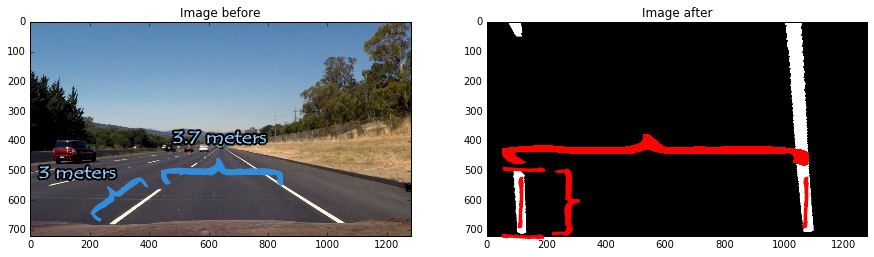

In [283]:
Image("./images_4_doc/distances.jpg")

In [284]:
# Compute meters per pix in X
mid_x, mid_y = int(birds_eye_white.shape[1]/2), int(birds_eye_white.shape[0]/2)

l_lim = np.mean(birds_eye_white[mid_y:, :mid_x].nonzero()[1])
r_lim = mid_x + np.mean(birds_eye_white[mid_y:, mid_x:].nonzero()[1])

x_pix_width = int(r_lim - l_lim)

# Compute meters per pix in Y
t_lim = np.min(birds_eye_white[mid_y:, :mid_x].nonzero()[0])
b_lim = np.max(birds_eye_white[mid_y:, :mid_x].nonzero()[0])

y_pix_height = b_lim - t_lim

print(x_pix_width)
print(y_pix_height)

953
210


In [285]:
xm_per_pix = 3.7/x_pix_wide
ym_per_pix = 3/y_pix_height

print("Meters per pixel in X: ", xm_per_pix)
print("Meters per pixel in Y: ", ym_per_pix)

Meters per pixel in X:  0.003882476390346275
Meters per pixel in Y:  0.0142857142857


In [286]:
def get_curvature_in_meters(image, pixels, xm_per_pix, ym_per_pix):
    
    left_lane_inds = pixels[0]
    right_lane_inds = pixels[1]
    
    nonzero = image.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    y_eval = image.shape[0]
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.abs(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.abs(2*right_fit_cr[0])

    poly = [left_fit_cr, right_fit_cr]
    curvature = [left_curverad, right_curverad]
    
    return curvature, poly

In [287]:
curvature, poly_meters = get_curvature_in_meters(birds_eye_yellow, pixels, xm_per_pix, ym_per_pix)
left_curvature, right_curvature = curvature
print(left_curvature, right_curvature)

166.37463466 793.650439277


In [288]:
# Let's compute the center of the vehicle

def get_deviation_from_center(image_shape, poly_meters, xm_per_pix):
    
    left_fit = poly_meters[0]
    right_fit = poly_meters[1]
    
    # We will measure the center of the car in the closest point to the car
    y_eval = image_shape[0]
    
    left_lane_center = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_center = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]


    lane_center = left_lane_center + (right_lane_center - left_lane_center)/2
    image_center = image_shape[1]/2 * xm_per_pix
    offset_in_metters = image_center - lane_center # Negative if we are in the left and positive if we are in the right
    # TODO check that this is happening
    
    return offset_in_metters

In [289]:
deviation = get_deviation_from_center(birds_eye_yellow.shape, poly_meters, xm_per_pix)
deviation

-930.34994470611218

## Warp the detected lane boundaries back onto the original image.

In [306]:
def draw_lane_unwarped(original_image, warped, poly, pixels, inv_M, plot=False):
    
    red = [255, 0, 0]
    blue = [0, 0, 255]
    
    left_fit = poly[0]
    right_fit = poly[1]
    
    left_lane_inds = pixels[0]
    right_lane_inds = pixels[1]
    
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Draw lane lines
    nonzero = warped.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    color_warp_lines = np.zeros_like(color_warp)
    color_warp_lines[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = blue
    color_warp_lines[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = red
    
    
    # Warp the blank back to original image space using inverse perspective matrix
    newwarp_lane = cv2.warpPerspective(color_warp, inv_M, (original_image.shape[1], original_image.shape[0])) 
    newwarp_lines = cv2.warpPerspective(color_warp_lines, inv_M, (original_image.shape[1], original_image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp_lane, 0.3, 0)
    result = cv2.addWeighted(result, 0.95, newwarp_lines, 1, 0)
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.imshow(result)
    
    return result

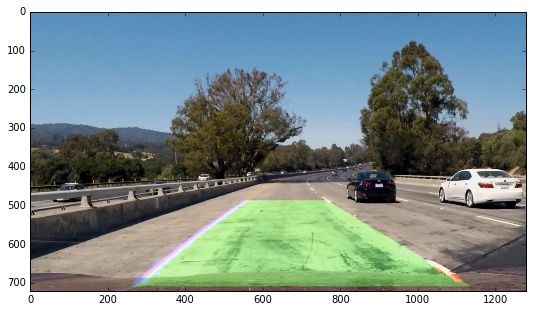

In [307]:
unwarped = draw_lane_unwarped(laboratory_rat_yellow, birds_eye_yellow, poly, pixels, inv_M, plot=True)

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [308]:
def draw_stats(unwarped, curvature, deviation, plot=False):
    
    final_im = unwarped.copy()
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    cv2.putText(final_im, 'Curvature: Left = %.2lf m, Right = %.2lf m' % (curvature[0], curvature[1]), \
                (70, 70), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(final_im, 'Lane deviation: %.2lf m' % deviation, \
                (70, 110), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.imshow(final_im)
    
    return final_im

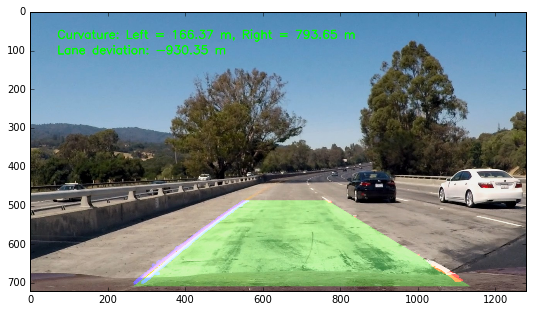

In [309]:
_ = draw_stats(unwarped, curvature, deviation, plot=True)

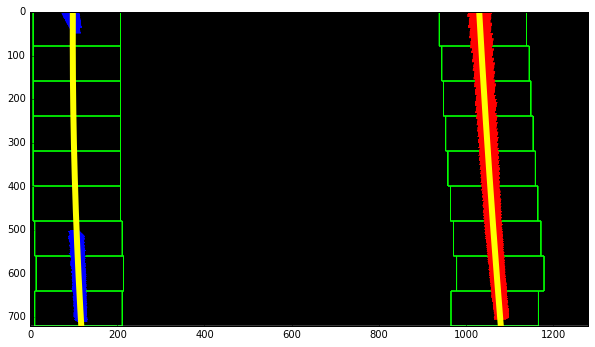

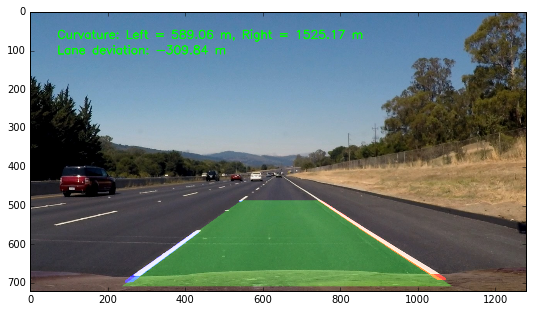

In [310]:
# Let's give a try with the other testing image

windows, pixels, poly = detect_lanes(birds_eye_white)
visualize_detected_lines(birds_eye_white, windows, pixels, poly)
curvature, poly_meters = get_curvature_in_meters(birds_eye_white, pixels, xm_per_pix, ym_per_pix)
deviation = get_deviation_from_center(birds_eye_white.shape, poly_meters, xm_per_pix)
unwarped = draw_lane_unwarped(laboratory_rat_white, birds_eye_white, poly, pixels, inv_M)
_ = draw_stats(unwarped, curvature, deviation, plot=True)

In [175]:
# Seems to be working. Time to wrap everything and give a try with the video.

In [177]:
meters_per_pix = [xm_per_pix, ym_per_pix]

pickle.dump(meters_per_pix, open("./meters_per_pix.pkl", "wb"))